## A4용지 Detect하여 Perspective (자동)

In [1]:
#A4 Detect//A4 찾아서 detect하고 contour 그리기
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('./images/inclass/lighton4.jpg')
img_ori = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Blurring
dst = cv2.medianBlur(img_gray, 9)  #medianBlur
dst2 = cv2.bilateralFilter(dst, 9, 100, 100) # Bilateral Filtering

#binary_img = cv2.adaptiveThreshold(dst2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 33, 5)
ret, binary_img = cv2.threshold(dst2, 170, 255, cv2.THRESH_BINARY)

ret_img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)

#img = img_ori.copy()

#추출된 contour 중 가장 큰 contour 찾기
max = 0;
index = -1;
for i in range(len(contour)):
   # print(max,i)
    if(max<len(contour[i])):        
        index = i
        max = len(contour[i])
        
cnt = contour[index]
epsilon1 = 0.1*cv2.arcLength(cnt, True)
approx1 = cv2.approxPolyDP(cnt, epsilon1, True)
cv2.drawContours(img, [approx1], 0, (0, 255, 0), 20)

plt.figure(figsize=(12,12))
plt.imshow(img)


In [2]:
#만약 정상적으로 4개의 점을 찾지 못하면 threshold를 이용하여 재시도
if (len(approx1)!=4):
    ret_threshold, binary_img = cv2.threshold(dst2,
                                          170,
                                          255,
                                          cv2.THRESH_BINARY)
    
    img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)

    img = img_ori.copy()   
    
    max = 0;
    index = -1;
    for i in range(len(contour)):
   # print(max,i)         if(max<len(contour[i])):        
            index = i
            max = len(contour[i])
            cnt=contour[index]

    cv2.drawContours(img, [cnt], 0, (255, 255, 0), 1)

    epsilon1 = 0.1*cv2.arcLength(cnt, True)
    approx1 = cv2.approxPolyDP(cnt, epsilon1, True)
    
    cv2.drawContours(img, [approx1], 0, (0, 255, 0), 20)
    plt.figure(figsize=(12,12))
    plt.imshow(img)

else:
    pass

In [3]:
#정확하게 A4를 perspect하도록 좌표 재조정
approx_list = []
for i in range(8):
    vals = approx1.item(i)
    approx_list.append(vals)
    
approx_list = np.array(approx_list)
pts1 = approx_list.reshape(4,-1).astype(np.float32)

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

pts1 = order_points(pts1)

import math
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

dist0_1 = distance(pts1[0], pts1[1])
dist1_2 = distance(pts1[1], pts1[2])


if(dist0_1 > dist1_2):
    pts2 = np.float32([[0,0],[1189,0],[1189,841],[0,841]]) # 이 상태는 좌측하단, 우측상단, 우측하단, 좌측상단임
elif(dist0_1 < dist1_2):
    pts2 = np.float32([[1189,0],[1189,841],[0,841], [0,0]]) # 이 상태는 좌측상단, 우측상단, 우측하단, 좌측하단임 

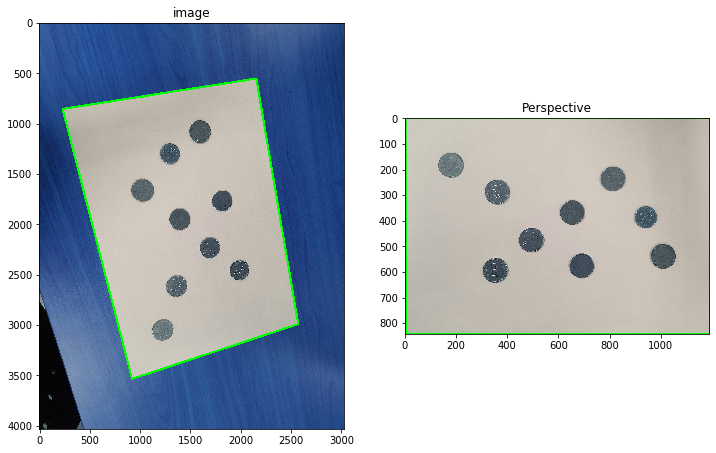

In [4]:
#Perspective Transform 
M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(img, M, (1189, 841))    

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

## 원 검출하기

In [5]:
#원의 윤곽 부각되도록
gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
line = cv2.bilateralFilter(blur, 5, 30, 30) # Bilateral Filtering
# Blur 처리해서 noise를 제거한다
#cimg = cv2.cvtColor(line, cv2.COLOR_GRAY2BGR)

cimg = dst.copy()


# 겹친 동전의 모양까지 원으로 검출하는 기준을 정의한다
circles = cv2.HoughCircles(line, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), param1=150, param2=20, minRadius=15, maxRadius=50)
circles = np.uint16(np.around(circles))

fivehund = 0
onehund = 0
fifty = 0
ten = 0


# 위 조건에 맞춰 cimg에 동전별로 원을 그린다
for circ in circles[0,:]:
    if circ[2] >= 50: #or circ[2] >= 38 or circ[2] >= 28:
        fivehund += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,255,0) ,2)
    elif circ[2] >= 45: #or circ[2] >= 35 or circ[2] >= 25:
        onehund += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,255) ,2)
    elif circ[2] >= 40: #or circ[2] >= 22:
        fifty += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,0) ,2)
    else:
        ten += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (255,0,0), 2)

# 동전 좌표 확인하기
count = circles[0,:]        # 인식된 원의 개수를 count라고 지정한다
# len(count)
c_array = circles.reshape(len(count), -1)                      # 검출된 원의 개수를 행의 개수로 하는 배열을 array라고 지정한다
radiusSet = c_array[:,-1]


# 총액 계산하기
total = (500 * fivehund + 100 * onehund + 50 * fifty + 10 * ten)

print('500원: {} 개'.format(fivehund),
      '\n100원: {} 개'.format(onehund),
      '\n 50원: {} 개'.format(fifty),
      '\n 10원: {} 개'.format(ten))
print('동전 총합: {} 원'.format(total))

500원: 0 개 
100원: 8 개 
 50원: 1 개 
 10원: 0 개
동전 총합: 850 원
